In [3]:
#import Libraries
!pip install kaggle 
!pip install pandas sqlalchemy pyodbc
import kaggle

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
#download dataset using kaggle API
!kaggle datasets download ankitbansal06/retail-orders -f orders.csv

Dataset URL: https://www.kaggle.com/datasets/ankitbansal06/retail-orders
License(s): CC0-1.0
orders.csv: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# #extract file from zip file
# import zipfile
# zip_ref = zipfile.ZipFile('orders.csv.zip')
# zip_ref.extractall() #extract file to dir
# zip_ref.close() #close file

In [7]:
#Read data from the file and handle null values
import pandas as pd
df = pd.read_csv('orders.csv',na_values=['Not Available', 'unknown'])
df['Ship Mode'].unique()


array(['Second Class', 'Standard Class', nan, 'First Class', 'Same Day'],
      dtype=object)

In [8]:
#Rename columns names and make them lower case and replace space with underscore
#df.rename(columns={'Order Id':'order_id', 'City': 'city'}) 
#df.columns=df.columns.str.lower()
#df.columns=df.columns.str.replace(' ','_')
df.head(5)

,Order Id,Order Date,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub Category,Product Id,cost price,List Price,Quantity,Discount Percent
0,1,2023-03-01,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,FUR-BO-10001798,240,260,2,2
1,2,2023-08-15,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,FUR-CH-10000454,600,730,3,3
2,3,2023-01-10,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,OFF-LA-10000240,10,10,2,5
3,4,2022-06-18,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,FUR-TA-10000577,780,960,5,2
4,5,2022-07-13,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,OFF-ST-10000760,20,20,2,5


In [13]:
#Drive new columns discount, sale price and profit
#Compute discount
df['discount'] = df['List Price'] * df['Discount Percent'] * 0.01  # Make sure your column names match!
#Compute sale_price
df['sale_price'] = df['List Price'] - df['discount']
#Compute profit
df['profit'] = df['sale_price'] - df['cost price']

df.head()


,Order Id,Order Date,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub Category,Product Id,cost price,List Price,Quantity,Discount Percent,discount,sale_price,profit
0,1,2023-03-01,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,FUR-BO-10001798,240,260,2,2,5.2,254.8,14.8
1,2,2023-08-15,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,FUR-CH-10000454,600,730,3,3,21.9,708.1,108.1
2,3,2023-01-10,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,OFF-LA-10000240,10,10,2,5,0.5,9.5,-0.5
3,4,2022-06-18,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,FUR-TA-10000577,780,960,5,2,19.2,940.8,160.8
4,5,2022-07-13,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,OFF-ST-10000760,20,20,2,5,1.0,19.0,-1.0


In [15]:
#convert order date from object data type to datetime
#df.dtypes
df.columns = df.columns.str.lower().str.replace(' ', '_')
df['order_date'] = pd.to_datetime(df['order_date'], format="%Y-%m-%d")

In [16]:
df.columns

Index(['order_id', 'order_date', 'ship_mode', 'segment', 'country', 'city',
       'state', 'postal_code', 'region', 'category', 'sub_category',
       'product_id', 'cost_price', 'list_price', 'quantity',
       'discount_percent', 'discount', 'sale_price', 'profit'],
      dtype='object')

In [17]:
#drop cost price, list price and discount percent columns
df.drop(['list_price', 'cost_price', 'discount_percent'], axis=1, inplace=True)

In [18]:
df.columns

Index(['order_id', 'order_date', 'ship_mode', 'segment', 'country', 'city',
       'state', 'postal_code', 'region', 'category', 'sub_category',
       'product_id', 'quantity', 'discount', 'sale_price', 'profit'],
      dtype='object')

In [20]:
#Connect to sql server 
import sqlalchemy as sal
from sqlalchemy import create_engine

engine = sal.create_engine(
    'mssql+pyodbc://LAPTOP-V3LL5JD7\\SQLEXPRESS/mydatabase?driver=ODBC+DRIVER+17+FOR+SQL+SERVER'
)
conn = engine.connect()


In [21]:
#Load the data into sql server using append option
df.to_sql('df_orders', con=conn, index=False, if_exists = 'append')

38

### Visualization

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

##### ----Top 10 highest revenue generating products----

In [31]:
top_products = df.groupby('product_id')['sale_price'].sum().sort_values(ascending=False).head(10)

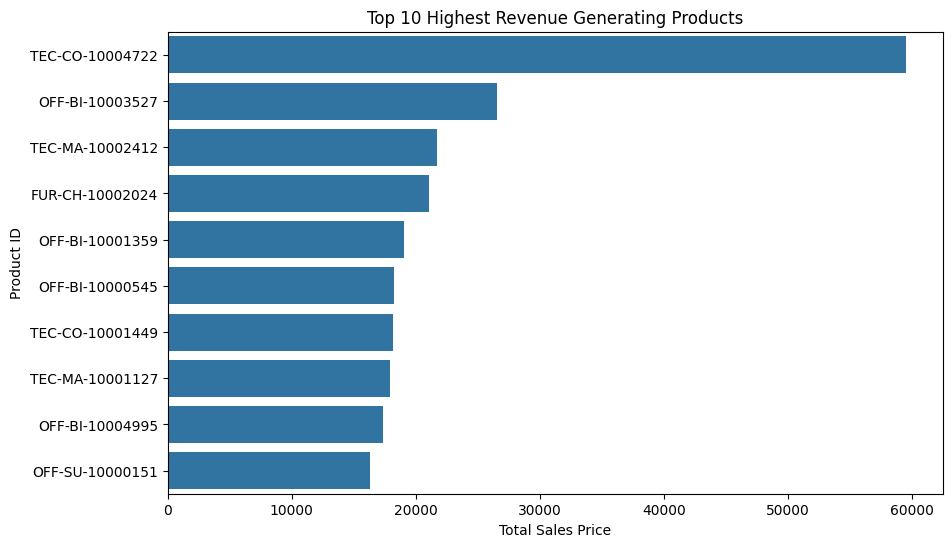

In [32]:
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Highest Revenue Generating Products')
plt.xlabel('Total Sales Price')
plt.ylabel('Product ID')
plt.show()

##### Top 5 selling products by region

In [35]:
# Group by region and product_id, sum sales
region_product_sales = df.groupby(['region', 'product_id'])['sale_price'].sum().reset_index()

# Rank products by sales inside each region
region_product_sales['rank'] = region_product_sales.groupby('region')['sale_price']\
    .rank(method='first', ascending=False)

# Filter top 5 products per region
top5_region_products = region_product_sales[region_product_sales['rank'] <= 5]


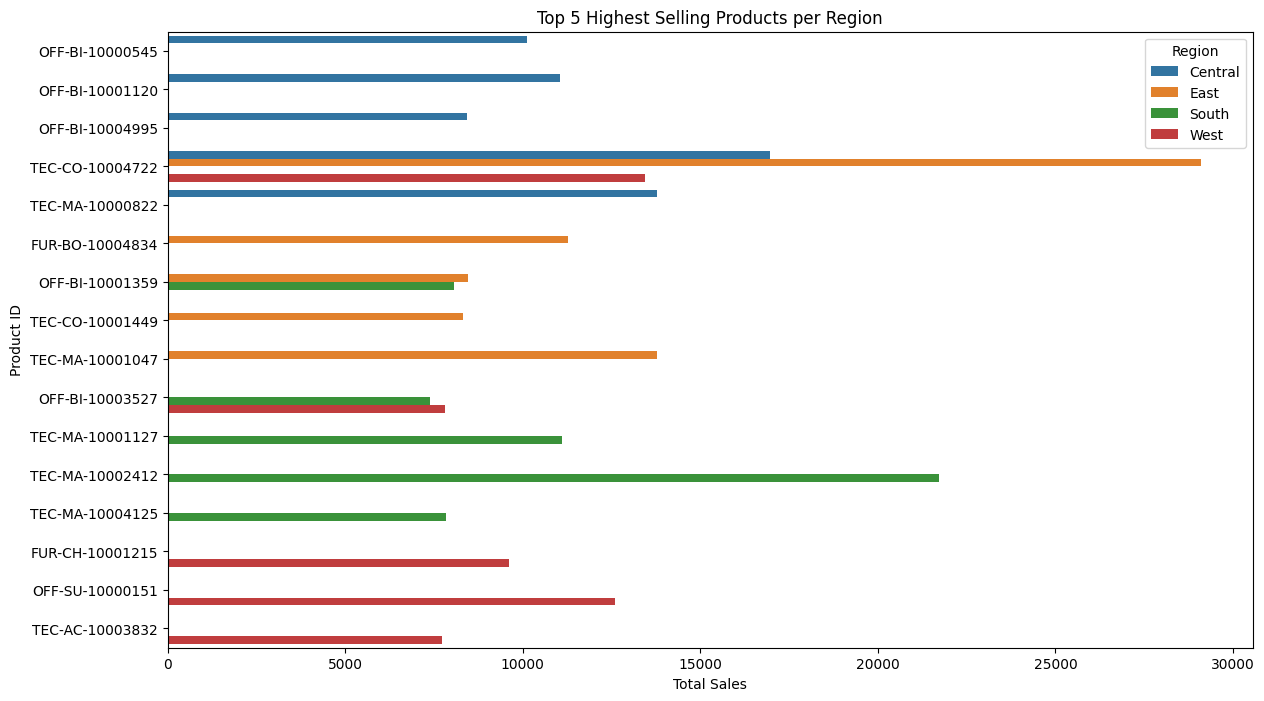

In [36]:
plt.figure(figsize=(14,8))
sns.barplot(x='sale_price', y='product_id', hue='region', data=top5_region_products)
plt.title('Top 5 Highest Selling Products per Region')
plt.xlabel('Total Sales')
plt.ylabel('Product ID')
plt.legend(title='Region')
plt.show()

##### --------Calculate Monthly sales for each year---------

In [37]:
# order_date as datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Extract year and month
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month

# Group by year and month, sum sales
monthly_sales = df.groupby(['order_year', 'order_month'])['sale_price'].sum().unstack(level=0).fillna(0)


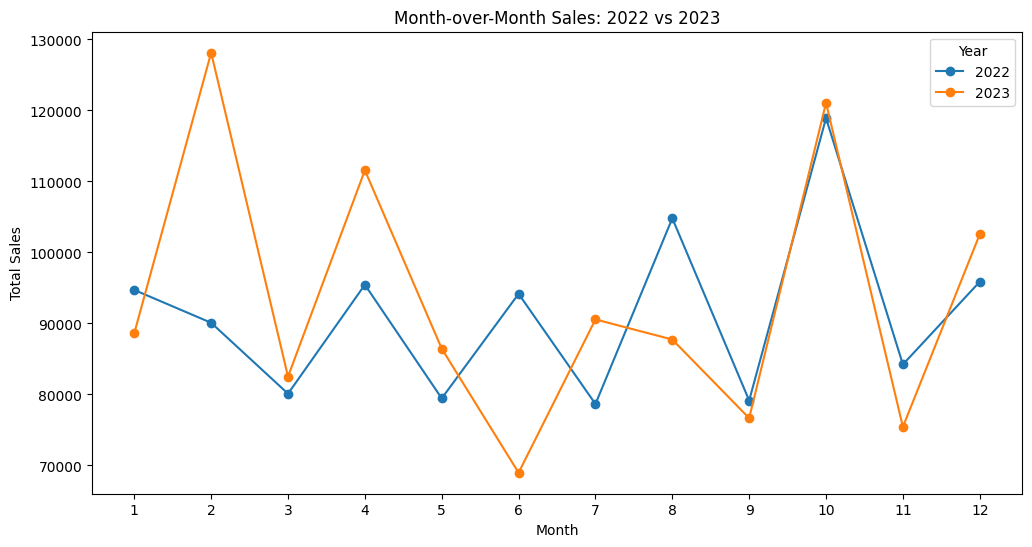

In [38]:
monthly_sales.plot(kind='line', figsize=(12,6), marker='o')
plt.title('Month-over-Month Sales: 2022 vs 2023')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1,13))
plt.legend(title='Year')
plt.show()

##### --------Which month had highest sales---------

In [40]:
# Format order_date as year-month string
df['order_year_month'] = df['order_date'].dt.strftime('%Y%m')

# Group sales by category and month
category_month_sales = df.groupby(['category', 'order_year_month'])['sale_price'].sum().reset_index()

# Rank months by sales within each category
category_month_sales['rank'] = category_month_sales.groupby('category')['sale_price']\
    .rank(method='first', ascending=False)

# Filter to top month per category
top_month_per_category = category_month_sales[category_month_sales['rank'] == 1]


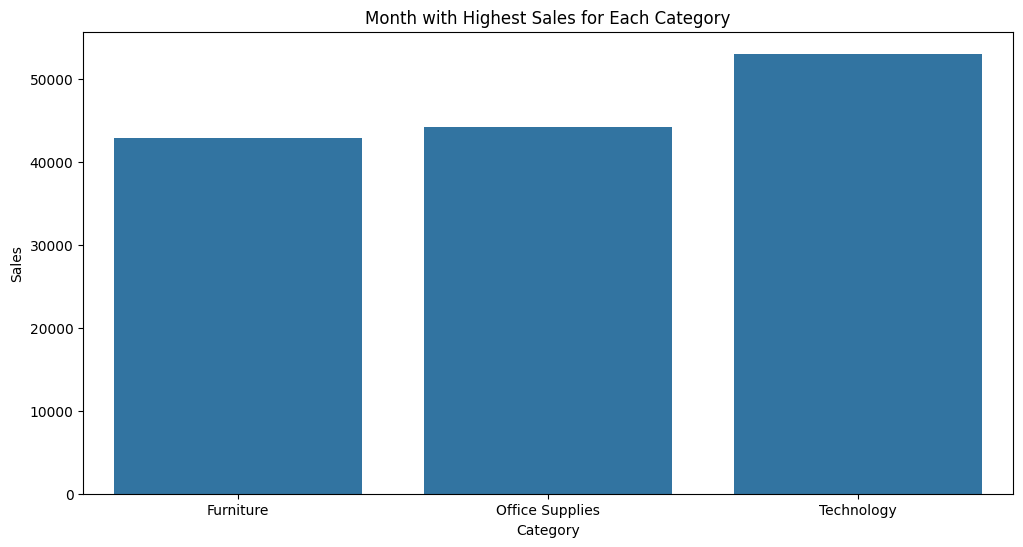

In [46]:
plt.figure(figsize=(12,6))
sns.barplot(x='category', y='sale_price', data=top_month_per_category)
plt.title('Month with Highest Sales for Each Category')
plt.ylabel('Sales')
plt.xlabel('Category')
plt.show()